In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import IterableDataset, DataLoader
import numpy as np
import pandas as pd
import random
import os

In [2]:
def set_seed(seed):
    """
    Set seed for reproducibility.
    
    Args:
        seed (int): Seed value to use
    """
    # Python random module
    import random
    random.seed(seed)
    
    # NumPy
    import numpy as np
    np.random.seed(seed)
    
    # PyTorch
    import torch
    torch.manual_seed(seed)
    
    # PyTorch CUDA
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        
        # Additional settings for complete determinism
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


In [3]:
# model with residiual connections
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

class convLayer(nn.Module):
    """
    Convolution block with skip (residual) connection
    """
    def __init__(self, input_channels, out_channels, kernel_size=8):
        super(convLayer, self).__init__()
        self.input_channels = input_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.conv = nn.Conv1d(
            in_channels=self.input_channels,
            out_channels=self.out_channels,
            kernel_size=self.kernel_size,
            stride=1,
            padding="same"
        )
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.gelu1 = nn.GELU()
        if input_channels != out_channels:
            self.proj = nn.Linear(input_channels, out_channels)
        else:
            self.proj = None
        self.gelu2 = nn.GELU()
            
    def forward(self, x):
        out = x.permute(0, 2, 1)
        out = self.gelu1(self.conv(out))
        out = out.permute(0, 2, 1)
        skip = x if self.proj is None else self.proj(x)
        x = skip + out
        x = x.permute(0, 2, 1)
        x = self.bn1(x)
        x = x.permute(0, 2, 1)
        return x

class ModelResNet(nn.Module):
    def __init__(self, base=32):
        super().__init__()
        self.input_ch = 206
        # Downstream layers
        self.enc1 = convLayer(self.input_ch, base*4)
        self.enc2 = convLayer(base*4, base*2)
        self.enc3 = convLayer(base*2, base)

        # Upstream layers
        self.up2 = convLayer(base, base*2)
        self.up1 = convLayer(base*2, base*4)
        self.up0 = convLayer(base*4, base*8) 
        self.flatten = nn.Flatten()

        #Dense layers
        self.linear1 = nn.Linear(base*8, base)
        self.activation = nn.GELU()
        self.linear2 = nn.Linear(base, 1)
        self.activation = nn.GELU()

    def forward(self, x):    
        x = self.enc1(x)
        x = self.enc2(x)
        x = self.enc3(x)
        x = self.up2(x)
        x = self.up1(x)
        x = self.up0(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        out = x.squeeze(1)
        return out


In [4]:
# a simple CNN model with bottleneck
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

class convLayer(nn.Module):
    """
    Convolution block with GELU activation
    """
    def __init__(self, input_channels, out_channels, kernel_size=8):
        super(convLayer, self).__init__()
        self.input_channels = input_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.conv = nn.Conv1d(
            in_channels=self.input_channels,
            out_channels=self.out_channels,
            kernel_size=self.kernel_size,
            stride=1,
            padding="same"
        )
        self.gelu = nn.GELU()

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.gelu(self.conv(x))
        x = x.permute(0, 2, 1)
        return x

class ModelCNN(nn.Module):
    def __init__(self, input_dim=206, base=32):
        super().__init__()
        self.input_ch = input_dim
        # Encoder
        self.enc1 = convLayer(self.input_ch, base*4)      
        self.enc2 = convLayer(base*4, base*2)
        self.enc3 = convLayer(base*2, base)

        # Decoder
        self.up2 = convLayer(base, base*2)
        self.up1 = convLayer(base*2, base*4)
        self.up0 = convLayer(base*4, base*8) 
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(base*8, base)
        self.activation = nn.GELU()
        self.linear2 = nn.Linear(base, 1)
        self.activation = nn.GELU()

    def forward(self, x):    
        x = self.enc1(x)
        x = self.enc2(x)
        x = self.enc3(x)
        x = self.up2(x)
        x = self.up1(x)
        x = self.up0(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        out = x.squeeze(1)
        return out


In [5]:
# custom metric for evaluation
class customMetrics():
    def __init__(self, delta=0.1):
        self.delta=delta
        
    def accuracy_mae(self, preds, targets):
        fraction = torch.zeros(preds.size(0))
        fraction[torch.abs(preds - targets) <= self.delta] = 1
        n = torch.count_nonzero(fraction)
        return n

In [6]:
dataset = pd.read_csv('Tables/df_labeled.tsv', sep='\t')
dataset = dataset.drop("Unnamed: 0", axis=1)
dataset = dataset.to_numpy()
dataset.shape

(7258, 207)

In [7]:
# train/val split
X, y = dataset[:, :-1], dataset[:, -1]
X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size=0.2, random_state=42, stratify=(y>0.5))
print(X_tr.shape)
print(y_tr.shape)

X_tr_t = torch.from_numpy(X_tr).unsqueeze(1)
X_va_t = torch.from_numpy(X_va).unsqueeze(1)
y_tr_t = torch.from_numpy(y_tr)
y_va_t = torch.from_numpy(y_va)

train_loader = DataLoader(TensorDataset(X_tr_t, y_tr_t), batch_size=1024, shuffle=True)
val_loader = DataLoader(TensorDataset(X_va_t, y_va_t), batch_size=1024, shuffle=False)

(5806, 206)
(5806,)


In [8]:
seed = 125

set_seed(seed)

model = ModelCNN(base=32)
device = torch.device('cuda:1')
model.to(device)

ModelCNN(
  (enc1): convLayer(
    (conv): Conv1d(206, 128, kernel_size=(8,), stride=(1,), padding=same)
    (gelu): GELU(approximate='none')
  )
  (enc2): convLayer(
    (conv): Conv1d(128, 64, kernel_size=(8,), stride=(1,), padding=same)
    (gelu): GELU(approximate='none')
  )
  (enc3): convLayer(
    (conv): Conv1d(64, 32, kernel_size=(8,), stride=(1,), padding=same)
    (gelu): GELU(approximate='none')
  )
  (up2): convLayer(
    (conv): Conv1d(32, 64, kernel_size=(8,), stride=(1,), padding=same)
    (gelu): GELU(approximate='none')
  )
  (up1): convLayer(
    (conv): Conv1d(64, 128, kernel_size=(8,), stride=(1,), padding=same)
    (gelu): GELU(approximate='none')
  )
  (up0): convLayer(
    (conv): Conv1d(128, 256, kernel_size=(8,), stride=(1,), padding=same)
    (gelu): GELU(approximate='none')
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=256, out_features=32, bias=True)
  (activation): GELU(approximate='none')
  (linear2): Linear(in_features

In [9]:
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d) or isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight' in name:  # Apply initialization only to weight tensors
                if param.dim() >= 2:  # Ensure the tensor is at least 2D
                    nn.init.kaiming_uniform_(param.data, mode='fan_in', nonlinearity='relu')
                    print("Kaiming uniform is applied.")
                else:
                    nn.init.uniform_(param.data, -0.08, 0.08)  # Fallback for 1D tensors
            elif 'bias' in name:  # Initialize biases
                nn.init.constant_(param.data, 0)

# Apply to model
model.apply(init_weights)
print(model)

Kaiming uniform is applied.
Kaiming uniform is applied.
ModelCNN(
  (enc1): convLayer(
    (conv): Conv1d(206, 128, kernel_size=(8,), stride=(1,), padding=same)
    (gelu): GELU(approximate='none')
  )
  (enc2): convLayer(
    (conv): Conv1d(128, 64, kernel_size=(8,), stride=(1,), padding=same)
    (gelu): GELU(approximate='none')
  )
  (enc3): convLayer(
    (conv): Conv1d(64, 32, kernel_size=(8,), stride=(1,), padding=same)
    (gelu): GELU(approximate='none')
  )
  (up2): convLayer(
    (conv): Conv1d(32, 64, kernel_size=(8,), stride=(1,), padding=same)
    (gelu): GELU(approximate='none')
  )
  (up1): convLayer(
    (conv): Conv1d(64, 128, kernel_size=(8,), stride=(1,), padding=same)
    (gelu): GELU(approximate='none')
  )
  (up0): convLayer(
    (conv): Conv1d(128, 256, kernel_size=(8,), stride=(1,), padding=same)
    (gelu): GELU(approximate='none')
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=256, out_features=32, bias=True)
  (activation): 

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 645,857 trainable parameters


In [11]:
curves_col = {"train": [],
              "validation": [],
             }

checkpoints = f"Model/checkpoints" #write your path to save model checkpoints
os.makedirs(checkpoints, exist_ok=True)

# ----- Training -----
criterion = nn.L1Loss(reduction = 'mean')
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0001)
delta = 0.1 # parameter for accuracy, see customMetrics
metric = customMetrics(delta=delta)

n_training = 1000
best_val = float('inf')
for epoch in range(n_training):
    model.train()
    tr_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device=device, dtype=torch.float32)
        yb = yb.to(device=device, dtype=torch.float32)

        optimizer.zero_grad()
        preds = model(xb)
        # print(preds.shape)
        loss = criterion(preds, yb)
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        loss.backward()
        optimizer.step()
        tr_loss += loss.item() * xb.size(0)

    model.eval()
    va_loss = 0.0
    va_acc  = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device=device, dtype=torch.float32)
            yb = yb.to(device=device, dtype=torch.float32)
            preds = model(xb)
            # print(preds.shape)
            loss = criterion(preds, yb)
            va_loss += loss.item() * xb.size(0)
            va_acc  += metric.accuracy_mae(preds, yb)

    tr_loss /= len(train_loader.dataset)
    va_loss /= len(val_loader.dataset)
    va_acc  /= len(val_loader.dataset)
    print(f"Epoch {epoch+1:02d} | train loss {tr_loss:.4f} | val loss {va_loss:.4f} | val acc(thr={delta}) {va_acc:.3f}")
    curves_col["train"].append(tr_loss)
    curves_col["validation"].append(va_loss)

    # Save model checkpoint for after specific epoch:
    if epoch >= 699:
        checkpoint_path = f'{checkpoints}/model_epoch_{epoch+1}.pth'
        torch.save(model.state_dict(), checkpoint_path)

/home/vmamontov/.conda/envs/torch/lib/python3.10/site-packages/torch/nn/modules/conv.py:370: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv1d(


Epoch 01 | train loss 0.3785 | val loss 0.3154 | val acc(thr=0.1) 0.309
Epoch 02 | train loss 0.2843 | val loss 0.2431 | val acc(thr=0.1) 0.139
Epoch 03 | train loss 0.2421 | val loss 0.2477 | val acc(thr=0.1) 0.244
Epoch 04 | train loss 0.2319 | val loss 0.2297 | val acc(thr=0.1) 0.169
Epoch 05 | train loss 0.2164 | val loss 0.2040 | val acc(thr=0.1) 0.260
Epoch 06 | train loss 0.1915 | val loss 0.1868 | val acc(thr=0.1) 0.245
Epoch 07 | train loss 0.1739 | val loss 0.1684 | val acc(thr=0.1) 0.385
Epoch 08 | train loss 0.1593 | val loss 0.1584 | val acc(thr=0.1) 0.468
Epoch 09 | train loss 0.1497 | val loss 0.1478 | val acc(thr=0.1) 0.533
Epoch 10 | train loss 0.1412 | val loss 0.1439 | val acc(thr=0.1) 0.573
Epoch 11 | train loss 0.1371 | val loss 0.1352 | val acc(thr=0.1) 0.590
Epoch 12 | train loss 0.1313 | val loss 0.1317 | val acc(thr=0.1) 0.599
Epoch 13 | train loss 0.1258 | val loss 0.1294 | val acc(thr=0.1) 0.612
Epoch 14 | train loss 0.1212 | val loss 0.1262 | val acc(thr=0.1

Min validation loss is 0.05954964060757114 on epoch 720


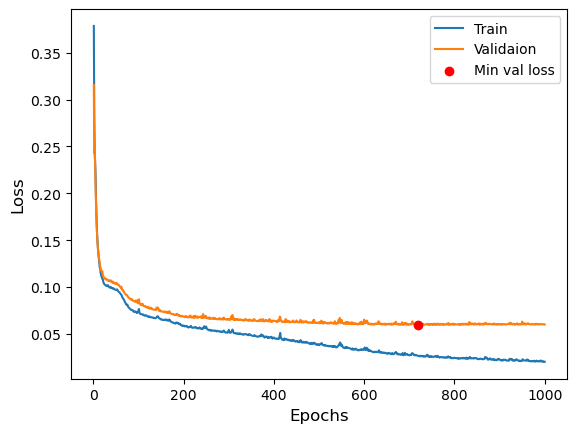

In [12]:
import matplotlib.pyplot as plt

min_val = min(curves_col["validation"])
optimal_epoch = curves_col["validation"].index(min_val) + 1

print(f"Min validation loss is {min_val} on epoch {optimal_epoch}")


plt.plot(np.arange(1, n_training+1), curves_col["train"], label="Train", zorder=0)
plt.plot(np.arange(1, n_training+1), curves_col["validation"], label="Validaion", zorder=1)
plt.scatter(optimal_epoch, min_val, color='red', alpha=1.0, label="Min val loss", zorder=2)
plt.ylabel("Loss", fontsize=12)
plt.xlabel("Epochs", fontsize=12)
plt.legend()
plt.savefig("/netscratch/dep_psl/grp_rgo/vm/MetaSynCom/Model/training_curves.pdf", format="pdf", bbox_inches="tight")
plt.show()
plt.close()

In [13]:
# load the best model based on the training curves
checkpoint_path = f"Model/checkpoints/model_epoch_{optimal_epoch}.pth"

model.load_state_dict(torch.load(checkpoint_path, weights_only=True))
model.to(device)
model

ModelCNN(
  (enc1): convLayer(
    (conv): Conv1d(206, 128, kernel_size=(8,), stride=(1,), padding=same)
    (gelu): GELU(approximate='none')
  )
  (enc2): convLayer(
    (conv): Conv1d(128, 64, kernel_size=(8,), stride=(1,), padding=same)
    (gelu): GELU(approximate='none')
  )
  (enc3): convLayer(
    (conv): Conv1d(64, 32, kernel_size=(8,), stride=(1,), padding=same)
    (gelu): GELU(approximate='none')
  )
  (up2): convLayer(
    (conv): Conv1d(32, 64, kernel_size=(8,), stride=(1,), padding=same)
    (gelu): GELU(approximate='none')
  )
  (up1): convLayer(
    (conv): Conv1d(64, 128, kernel_size=(8,), stride=(1,), padding=same)
    (gelu): GELU(approximate='none')
  )
  (up0): convLayer(
    (conv): Conv1d(128, 256, kernel_size=(8,), stride=(1,), padding=same)
    (gelu): GELU(approximate='none')
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=256, out_features=32, bias=True)
  (activation): GELU(approximate='none')
  (linear2): Linear(in_features

In [14]:
# test the model
sample = X_va
sample = torch.from_numpy(sample).unsqueeze(1)
sample = sample.to(device=device, dtype=torch.float32)
print(sample.shape)
# print(xb.shape)
pred = model(sample)
pred = pred.to(device='cpu').detach().numpy()
print(pred.shape)

torch.Size([1452, 1, 206])
(1452,)


In [15]:
# prepare data for accuracy plot (y_va - validation target, pred - prediciton by the model)
res = np.abs(y_va - pred)
error_list = []
percentage = []
for i in range(1, 45, 1):
    error = i/100
    mask = (res < error)
    sub = res[mask]
    # print(sub.shape)
    percentage.append(sub.shape[0] / res.shape[0] * 100)
    error_list.append(error)

In [16]:
print(error_list[14]) # the choosen delta between predicted and real data (delta = 0.15 looks small enough)
print(percentage[14]) # the fraction of predicted data in percent closer to the real data than the delta

0.15
89.32506887052341


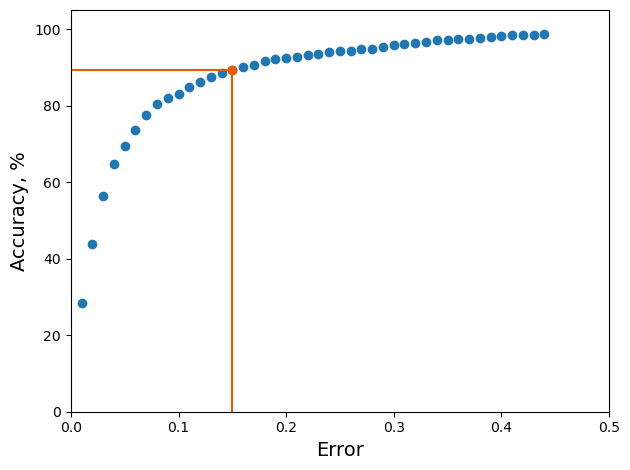

In [17]:
plt.scatter(error_list, percentage)
plt.vlines(error_list[14], ymin=0.0, ymax=percentage[14], color="#EB5B00")
plt.hlines(percentage[14], xmin=0.0, xmax=error_list[14], color="#EB5B00")
plt.scatter(error_list[14], percentage[14], color="#EB5B00")
plt.ylabel("Accuracy, %", size=14)
plt.xlabel("Error", size=14)
plt.ylim(0, 105)
plt.xlim(0, 0.5)
plt.tight_layout()
plt.savefig("/netscratch/dep_psl/grp_rgo/vm/MetaSynCom/Plots/Error_Accumulation.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [18]:
# load the original table
table = pd.read_csv("Tables/df_labeled.tsv", sep="\t")
table = table.drop("Unnamed: 0", axis=1)
table

,F1,F2,F3,F4,S1,S2,S3,S4,S5,S6,...,Source_182,Source_183,Source_184,Source_185,Source_186,Source_187,Source_188,Source_189,Source_190,AUC
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0.197254
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0.164838
2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0.210681
3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0.527753
4,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0.790775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7253,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
7254,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
7255,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
7256,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000


In [19]:
name_map = {}
for i, j in enumerate(table.columns[:-1]):
    # print(j)
    if i == 15:
        # name_map[i] = "Negative"
        continue
    # name = j.split("_")[1]
    # name_map[i] = name
    # print(i, name)
    name_map[i] = j
    
# print(name_map)

In [20]:
sc = X_va[:, :15]
carbons = X_va[:, 16:]
print(sc.shape)
print(carbons.shape)

(1452, 15)
(1452, 190)


In [21]:
sc_map = {}
for i, var in enumerate(sc):
    if np.sum(var) == 15:
        name = "FBSC"
    if np.sum(var) == 4:
        name = "FSC"
    if np.sum(var) == 11:
        name = "BSC"
    if np.sum(var) == 1:
        index = np.where(var==1)[0][0]
        name = name_map[index]
    if np.sum(var) == 14:
        index = np.where(var==0)[0][0]
        name = f"FBSC - {name_map[index]}"
    sc_map[i] = name
    print(i, name)
        
# print(sc_map)

0 FBSC - S4
1 FBSC - S6
2 S11
3 FBSC - S4
4 FBSC - S4
5 FBSC - F1
6 S11
7 BSC
8 FBSC - S10
9 S10
10 FBSC - S11
11 S10
12 F3
13 F2
14 S6
15 FBSC - S2
16 FBSC
17 BSC
18 FBSC
19 FBSC - S8
20 FBSC - S11
21 FBSC - S11
22 F4
23 FBSC - F4
24 FBSC - S8
25 FSC
26 FSC
27 FBSC - S6
28 FBSC - F3
29 BSC
30 FBSC - S10
31 FBSC
32 FBSC
33 S9
34 FBSC - S1
35 F4
36 F3
37 FBSC - S5
38 FBSC - S2
39 S7
40 FSC
41 S6
42 FBSC - S8
43 FBSC - S1
44 S1
45 FBSC
46 FBSC - S4
47 FBSC
48 FBSC - F4
49 F1
50 F4
51 FBSC - F4
52 FBSC
53 FBSC - S6
54 FBSC
55 F2
56 BSC
57 S7
58 FBSC - F2
59 S6
60 S6
61 S7
62 FBSC - S3
63 FBSC
64 F2
65 FBSC
66 BSC
67 FBSC - S1
68 S2
69 S5
70 FBSC - S5
71 S4
72 S5
73 FBSC - S2
74 FBSC - S2
75 FSC
76 S8
77 FBSC - S8
78 S10
79 FBSC - F4
80 S3
81 S6
82 FBSC - S1
83 FBSC - F3
84 FBSC - S9
85 FSC
86 S5
87 FBSC - S7
88 F4
89 F4
90 FBSC - S1
91 FBSC - S7
92 FBSC - S10
93 BSC
94 S10
95 FBSC
96 FBSC - S1
97 FBSC - F3
98 S3
99 FBSC
100 FBSC - S2
101 S3
102 S10
103 FBSC - S10
104 FBSC - S10
105 F3
106

In [22]:
carbon_map = {}
for i, var in enumerate(carbons):
    if np.sum(var) == 0:
        name = "Negative"
        carbon_map[i] = name
    else:
        index = np.where(var==1)[0][0]
        name = name_map[index+16]
        carbon_map[i] = name
    print(i, name)

# print(carbon_map)

0 Source_123
1 Source_165
2 Source_62
3 Source_27
4 Source_189
5 Source_29
6 Source_112
7 Source_119
8 Source_110
9 Source_121
10 Source_22
11 Source_100
12 Source_135
13 Source_173
14 Source_104
15 Source_177
16 Source_186
17 Source_45
18 Source_185
19 Source_186
20 Source_130
21 Source_127
22 Source_47
23 Source_136
24 Source_171
25 Source_10
26 Source_163
27 Source_107
28 Source_128
29 Source_164
30 Source_139
31 Source_179
32 Source_174
33 Source_137
34 Source_184
35 Source_39
36 Source_183
37 Source_34
38 Source_171
39 Source_112
40 Source_114
41 Source_173
42 Source_179
43 Source_21
44 Source_65
45 Source_55
46 Source_184
47 Source_130
48 Source_151
49 Source_114
50 Source_79
51 Source_4
52 Source_15
53 Source_140
54 Source_50
55 Source_171
56 Source_63
57 Source_184
58 Source_118
59 Source_110
60 Source_157
61 Source_87
62 Source_111
63 Source_17
64 Source_182
65 Source_96
66 Source_61
67 Source_81
68 Source_144
69 Source_100
70 Source_59
71 Source_117
72 Source_58
73 Source_159

In [23]:
y_names = ["FBSC", "FSC", "BSC"]
for i in table.columns[:15]:
    name = i
    # name = i.split("_")[1]
    y_names.append(name)

for i in table.columns[:15]:
    # name = i.split("_")[1]
    name = i
    y_names.append(f"FBSC - {name}")
# y_names.append("Negative")
print(y_names)
print(len(y_names))

['FBSC', 'FSC', 'BSC', 'F1', 'F2', 'F3', 'F4', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'FBSC - F1', 'FBSC - F2', 'FBSC - F3', 'FBSC - F4', 'FBSC - S1', 'FBSC - S2', 'FBSC - S3', 'FBSC - S4', 'FBSC - S5', 'FBSC - S6', 'FBSC - S7', 'FBSC - S8', 'FBSC - S9', 'FBSC - S10', 'FBSC - S11']
33


In [24]:
x_names = ["Negative"]
for i in table.columns[16:-1]:
    # name = i.split("_")[1]
    name = i
    x_names.append(name)
print(x_names)
print(len(x_names))

['Negative', 'Source_1', 'Source_2', 'Source_3', 'Source_4', 'Source_5', 'Source_6', 'Source_7', 'Source_8', 'Source_9', 'Source_10', 'Source_11', 'Source_12', 'Source_13', 'Source_14', 'Source_15', 'Source_16', 'Source_17', 'Source_18', 'Source_19', 'Source_20', 'Source_21', 'Source_22', 'Source_23', 'Source_24', 'Source_25', 'Source_26', 'Source_27', 'Source_28', 'Source_29', 'Source_30', 'Source_31', 'Source_32', 'Source_33', 'Source_34', 'Source_35', 'Source_36', 'Source_37', 'Source_38', 'Source_39', 'Source_40', 'Source_41', 'Source_42', 'Source_43', 'Source_44', 'Source_45', 'Source_46', 'Source_47', 'Source_48', 'Source_49', 'Source_50', 'Source_51', 'Source_52', 'Source_53', 'Source_54', 'Source_55', 'Source_56', 'Source_57', 'Source_58', 'Source_59', 'Source_60', 'Source_61', 'Source_62', 'Source_63', 'Source_64', 'Source_65', 'Source_66', 'Source_67', 'Source_68', 'Source_69', 'Source_70', 'Source_71', 'Source_72', 'Source_73', 'Source_74', 'Source_75', 'Source_76', 'Source_

In [25]:
# collect indices for heatmap
c_idx = []
for key in sc_map.keys():
    index = y_names.index(sc_map[key])
    c_idx.append(index)

r_idx = []
for key in carbon_map.keys():
    index = x_names.index(carbon_map[key])
    r_idx.append(index)

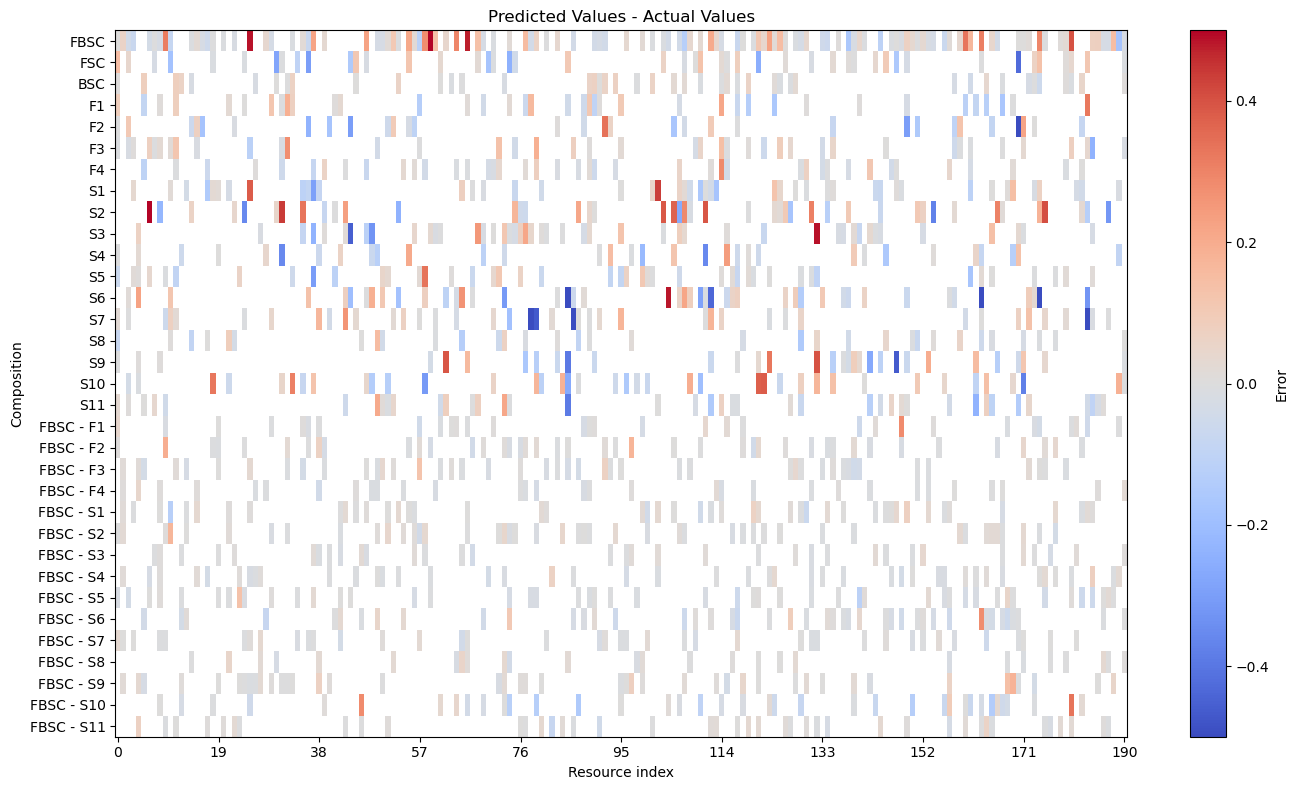

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Inputs:
comp = sc
res = carbons
y = pred - y_va

n_comp = comp.shape[1]
n_res  = res.shape[1]
n_comp = len(y_names)
n_res = len(x_names)

heat_sum   = np.zeros((n_comp, n_res), dtype=float)
heat_count = np.zeros((n_comp, n_res), dtype=int)

np.add.at(heat_sum,   (c_idx, r_idx), y)
np.add.at(heat_count, (c_idx, r_idx), 1)

heat = np.divide(
    heat_sum,
    heat_count,
    out=np.full_like(heat_sum, np.nan, dtype=float),
    where=heat_count > 0
)

masked_heat = np.ma.array(heat, mask=np.isnan(heat))

fig, ax = plt.subplots(figsize=(14, 8))
im = ax.imshow(masked_heat, cmap='coolwarm', origin="upper", aspect="auto", vmin=-.5, vmax=.5)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Error")

ax.set_xlabel("Resource index")
ax.set_ylabel("Composition")
ax.set_title("Predicted Values - Actual Values")

ax.set_yticks(np.arange(0, 33), labels=y_names)
ax.set_xticks(np.arange(0, n_res, max(1, n_res // 10)))

plt.tight_layout()
plt.savefig("Plots/Predicted_Error_Heatmap_labeled.pdf", format="pdf", bbox_inches='tight')
plt.show()
